In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)

In [2]:
# Read a CSV file into a DataFrame
csv_file_path = '../Dataset/XRP_dataset.csv'  # Replace with your CSV file path
xrp_df = pd.read_csv(csv_file_path)


In [3]:
def checkCrossOver(macd, signal_line):

    if macd > signal_line: 
        return 1
    elif macd < signal_line: 
        return -1
    else: 
        return 0

In [4]:
def getATR(df, period):
    
    # Calculate the True Range (TR)
    df['high_low'] = df['high'] - df['low']
    df['high_close'] = abs(df['high'] - df['close'].shift())
    df['low_close'] = abs(df['low'] - df['close'].shift())
    df['tr'] = df[['high_low', 'high_close', 'low_close']].max(axis=1)

    # Calculate the Average True Range (ATR)
    df['atr'] = df['tr'].rolling(window=period).mean()

    return df

In [5]:
def getADX(df, period):
    high = df['high']
    low  = df['low']

    plus_dm = high.diff()
    plus_dm[plus_dm < 0] = 0
    minus_dm = low.diff()
    minus_dm[minus_dm > 0] = 0

    atr = getATR(df, period)

    plus_di = 100 * (plus_dm.ewm(alpha = 1/period).mean()/atr['atr'])
    minus_di = abs(100 * (minus_dm.ewm(alpha = 1/period).mean() / atr['atr']))
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    adx = ((dx.shift(1) * (period - 1)) + dx) / period
    adx = adx.ewm(alpha=1/period).mean()
    return plus_di, minus_di, adx


In [6]:
xrp_df['EMA12'] = xrp_df['close'].ewm(span=12, adjust=False).mean()
xrp_df['EMA26'] = xrp_df['close'].ewm(span=26, adjust=False).mean()
xrp_df['MACD'] = xrp_df['EMA12'] - xrp_df['EMA26']
xrp_df['Signal_Line'] = xrp_df['MACD'].ewm(span=9, adjust=False).mean()

xrp_df['plus_di'] = pd.DataFrame(getADX(xrp_df, 6)[0]).rename(columns = {0:'plus_di'})
xrp_df['minus_di'] = pd.DataFrame(getADX(xrp_df, 6)[1]).rename(columns = {0:'minus_di'})
xrp_df['adx'] = pd.DataFrame(getADX(xrp_df, 6)[2]).rename(columns = {0:'adx'})

In [7]:
crossover = []
intersect_list = []
old_intersection = None
for index, row in xrp_df.iterrows():    

    # Add any additional logic here if needed
    intersection = checkCrossOver(row['MACD'], row['Signal_Line'])
    if old_intersection != intersection:
        intersect_list.append(1)
    else: intersect_list.append(0)

    old_intersection = intersection 


    crossover.append(intersection)

xrp_df['crossover'] = crossover
xrp_df['intersection'] = intersect_list

In [8]:
def checkMACD(EMA12, EMA26, MACD, signal_line):
    if EMA12 > EMA26 and MACD < signal_line:
        return 1  # Buy signal
    elif EMA12 < EMA26 and MACD > signal_line:
        return -1  # Sell signal
    else:
        return 0  # No signal
    

In [9]:
def checkADX(plus_di, minus_di, adx):
    if adx > 25 and plus_di > minus_di:
        return 1  # Buy signal
    elif adx > 25 and minus_di > plus_di:
        return -1  # Sell signal
    else:
        return 0  # No signal

In [10]:
def checkSignal(MACD, ADX):
    if MACD * ADX == 1:
        return 1
    else: return 0

In [11]:
def strategy(df):
    df['MACD_Signal'] = df.apply(lambda row: checkMACD(row['EMA12'], row['EMA26'], row['MACD'], row['Signal_Line']), axis=1)
    df['ADX_Signal'] = df.apply(lambda row: checkADX(row['plus_di'], row['minus_di'], row['adx']), axis=1)

    # Combine the signals
    df['Combined_Signal'] = df.apply(lambda row: checkSignal(row['MACD_Signal'], row['ADX_Signal']), axis=1)
    return df

In [12]:
#finalize dataset
xrp_df = strategy(xrp_df)

investment_value = 100

xrp_df['returns'] = pd.DataFrame(np.diff(xrp_df['close'], prepend=[0])).rename(columns = {0:'returns'})

strategy_ret = []
for i in range(len(xrp_df)):
    strategy_ret.append(xrp_df['returns'][i] * investment_value)

xrp_df['strategy_returns'] = strategy_ret


In [13]:
#strategy
investment = 100
profit = 0
hold = False
signal = []

i = 0
while i < len(xrp_df):
    if not hold:
        if xrp_df["Combined_Signal"][i] == 1:
            signal.append("buy")
            hold = True
        elif xrp_df["Combined_Signal"][i] == 0:
            signal.append("skip")
    else:
        if profit >= 5 or profit <= -2:
            investment += profit
            signal.append("sell")
            hold = False
            profit = 0
            while xrp_df["Combined_Signal"][i] == 1:
                signal.append("skip")
                i += 1
        elif xrp_df["Combined_Signal"][i] == 1:
            profit += xrp_df["strategy_returns"][i]
            signal.append("hold")
        elif xrp_df["Combined_Signal"][i] == 0:
            investment += profit
            signal.append("sell")
            hold = False
    i += 1

xrp_df['signal'] = signal

In [14]:
investment

np.float64(23519.03300000039)

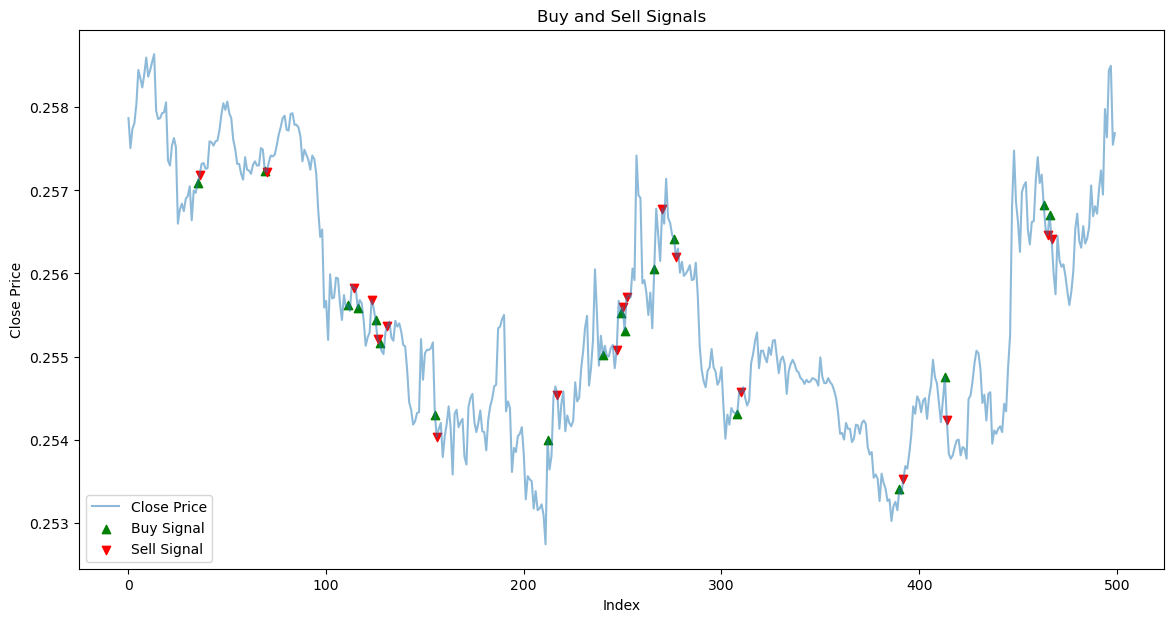

In [23]:
xrp_df_clone = xrp_df.iloc[:500].copy()


plt.figure(figsize=(14, 7))
plt.plot(xrp_df_clone['close'], label='Close Price', alpha=0.5)
buy_signals = xrp_df_clone[xrp_df_clone['signal'] == 'buy']
sell_signals = xrp_df_clone[xrp_df_clone['signal'] == 'sell']
plt.scatter(buy_signals.index, buy_signals['close'], label='Buy Signal', marker='^', color='green', alpha=1)
plt.scatter(sell_signals.index, sell_signals['close'], label='Sell Signal', marker='v', color='red', alpha=1)
plt.title('Buy and Sell Signals')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()
